# Advanced Lane Detection Algorithm

## Import Statements

In [70]:
#Import all necessary libraries

import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.patches import Polygon
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import glob

## Camera Calibration

In [71]:
#calculates camera matrix mtx and distortion coefficients dist.
#parameters: distorted image of chessboard, number of corners in x and y
#returns undistorted image of chessboard, mtx, dist
def cal_undistort(img, nx = 9 , ny = 6):
    
    #prepare vectors to store image and object points for calibration
    objpoints = [] 
    imgpoints = [] 

    objp = np.zeros((ny*nx,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)
    
    fnames = glob.glob("camera_cal/calibration*.jpg")
    
    for fname in fnames:
        img = mpimg.imread(fname)
        
        gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    
        #find corners in chessboard image
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
        
        if ret:    
            objpoints.append(objp)
            imgpoints.append(corners)

    #comoute mtx and dist
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    
    #undistort image
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    
    
    return undist, mtx, dist



In [72]:
#performs perspective transform on undistorted image and adds visualization of corners.
#paramteres: image, camera matrix, distortion coefficients, number of corners in x and y
#returns: unwarped and undistorted image, transformation matrix m
def corners_unwarp(img, mtx, dist, nx = 9, ny = 6):
    
    # undistort using mtx and dist
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    

    # convert to grayscale
    gray = cv2.cvtColor(undist,cv2.COLOR_RGB2GRAY)
    img_size = (gray.shape[1], gray.shape[0])
    
    # find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
  
    #  draw chessboard corners and perform perspective transformation       
    if ret == True:
        cv2.drawChessboardCorners(undist, (nx, ny), corners, ret)
        src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
        dst = np.float32([[0+100,0+100], [img_size[0]-100, 100], [img_size[0]-100, img_size[1]-100], [100, img_size[1]-100]])
        M = cv2.getPerspectiveTransform(src, dst)
        warped = cv2.warpPerspective(undist, M, img_size, flags=cv2.INTER_LINEAR)
        
        result = warped
        
 
    return result, M

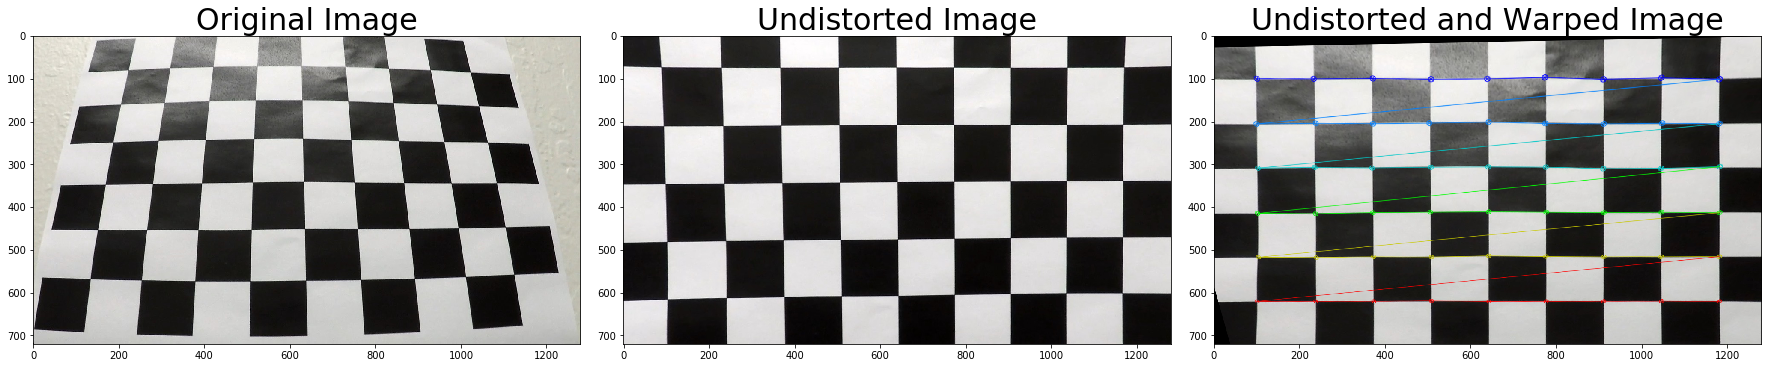

In [73]:
# visualize camera calibration steps on chessboard image

test_img = mpimg.imread('camera_cal/calibration3.jpg')

undistorted, mtx, dist = cal_undistort(test_img)
top_down, perspective_M = corners_unwarp(test_img, mtx, dist )

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test_img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
ax3.imshow(top_down)
ax3.set_title('Undistorted and Warped Image', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


## Load Test Image

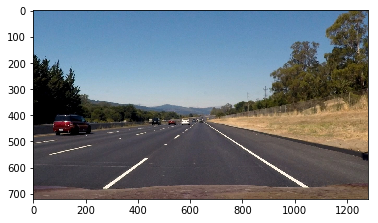

In [74]:
# load in test image
road_img = mpimg.imread('test_images/straight_lines2.jpg')
road_gray = cv2.cvtColor(road_img,cv2.COLOR_RGB2GRAY)
img_size = (road_gray.shape[1], road_gray.shape[0])
plt.imshow(road_img)

## Undistort Image

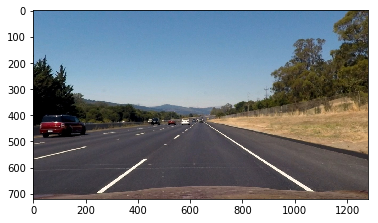

In [75]:
# undistort image using mtx and dist
road_undist = cv2.undistort(road_img, mtx, dist, None, mtx)
plt.imshow(road_undist)

## Perspective Tansformation

In [76]:
#performs perspective transformation on road image. Transforms image of front facing camera into birds-eye-perspective.
#parameters: road image (front facing), source and destination points for transformation (hard coded)
#returns: warped image (birds-eye-view), Inverse Transformation Matrix Minv (needed later in code to transform back), src and dst
def perspectiveTransform(img, src = None, dst = None):
    img_size = (img.shape[1], img.shape[0])
    
    #Define Source and Destination vertices for perspective transformation
    if src is None:
        src = np.float32([[240, 700], [580, 460], [705, 460], [1085, 700]])
    if dst is None:
        dst = np.float32([[250, 700], [250, 0], [1000, 0], [1000, 700]])
        
    #Compute Transformation Matrix M    
    M = cv2.getPerspectiveTransform(src, dst)
    
    #Compute Inverse-Transformation Matrix Minv
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    #Apply Perspective Transformation
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    
    return warped, Minv, src, dst

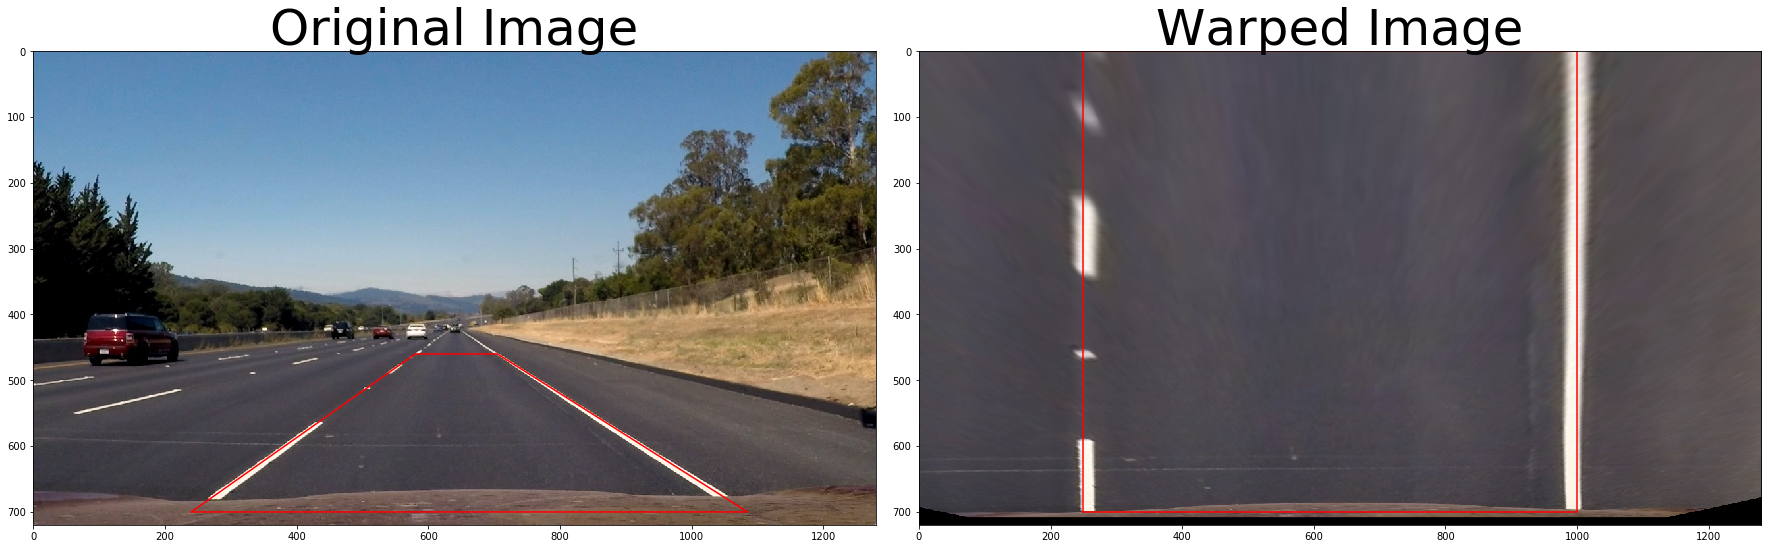

In [77]:
# visualize perspective transformation steps on road image
warped_img, Minv, src, dst = perspectiveTransform(road_undist, None, None)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(road_img)
ax1.set_title('Original Image', fontsize=50)
ax1.plot(Polygon(src).get_xy()[:, 0], Polygon(src).get_xy()[:, 1], color='red')
ax2.imshow(warped_img)
ax2.set_title('Warped Image', fontsize=50)
ax2.plot(Polygon(dst).get_xy()[:, 0], Polygon(dst).get_xy()[:, 1], color='red')
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

 ## Color and Gradient Thresholding

In [80]:
#Applies S-channel(from HSV image), R-channel (from RGB image) and X-gradient thrsholding
#to warped road image in order to detect lane-lines
#parameters: warped road image, s, r and sx thresholds
#returns: binary and stacked color binary of thresholded, warped road image
def color_gradient_thresholding(img, s_thresh=(90, 255), sx_thresh=(20, 200), r_thresh=(190, 255)):
    
    img = np.copy(img)
    
    # seperate r channel
    r_channel = img[:,:,0]
    
    # convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    # apply sobel x operator
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) 
    abs_sobelx = np.absolute(sobelx)
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # threshold s channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # threshold r channel
    r_binary = np.zeros_like(r_channel)
    r_binary[(r_channel >= r_thresh[0]) & (r_channel <= r_thresh[1])] = 1
    
    # stack all channels in color_binary
    color_binary = np.dstack((sxbinary, s_binary, r_binary)) * 255
    
    # combine thresholds in binary
    binary_warped = np.zeros_like(s_channel)    
    binary_warped[((s_binary == 1) & (sxbinary == 1)) 
                     | ((sxbinary == 1) & (r_binary == 1))
                     | ((s_binary == 1) & (r_binary == 1))] = 1
    
    return color_binary, binary_warped

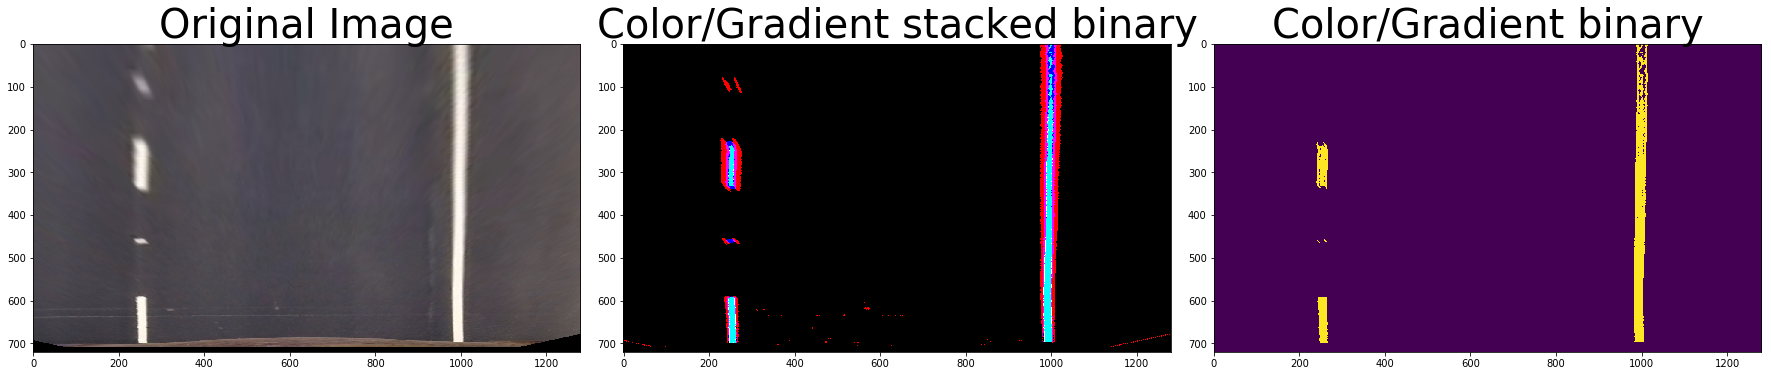

In [81]:
color_binary, binary_warped = color_gradient_thresholding(warped_img)
# Plot the result
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()

ax1.imshow(warped_img)
ax1.set_title('Original Image', fontsize=40)


ax2.imshow(color_binary)
ax2.set_title('Color/Gradient stacked binary', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

ax3.imshow(binary_warped)
ax3.set_title('Color/Gradient binary', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Lane Fitting

In [82]:
#Detects lane pixels in binary, warped road image by applying sliding window search
# and fits second order polynomial to lane pixels
#Parameters: binary, warped road image, return-flag (set true to return visualization output)
#Returns:Polynomial coefficients and points for left and right lane, (visualization image)
def find_lane_pixels(binary_warped, return_img = False):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    
    if return_img:
        # Create an output image to draw on and visualize the result
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))
        
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        # boundaries of the windows
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        if return_img:
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),
            (win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),
            (win_xright_high,win_y_high),(0,255,0), 2) 
        
        #Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        #If found > minpix pixels, recenter next window on their mean position 
        if (len(good_left_inds) > minpix):
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if (len(good_right_inds) > minpix):
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
            

            
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    #Fit second order polynomial
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    

    ## Visualization ##
    # Colors in the left and right lane regions
    if return_img:
        out_img[lefty, leftx] = [255, 0, 0]
        out_img[righty, rightx] = [0, 0, 255]

        # Plots the left and right polynomials on the lane lines
        for index in range(binary_warped.shape[0]):
            cv2.circle(out_img, (int(left_fitx[index]), int(ploty[index])), 3, (255,255,0))
            cv2.circle(out_img, (int(right_fitx[index]), int(ploty[index])), 3, (255,255,0))

        return (left_fit, right_fit), (left_fitx, ploty),  (right_fitx, ploty), out_img
    
    else:
        return (left_fit, right_fit), (left_fitx, ploty),  (right_fitx, ploty)


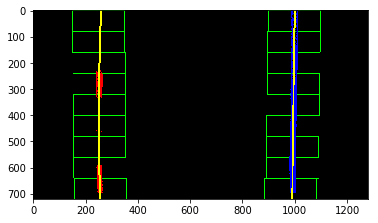

In [83]:
# Visualize window seach
lanes_fit,  right_points, left_points, out_img = find_lane_pixels(binary_warped, True)

plt.imshow(out_img)

In [84]:
#If fitted polynomials from last iteration are given, search for lane pixels within margin of them
#Parameters: binary, warped road image, left/right fits from last iteration, return_img flag(set true to return visualization output)
#Returns: Polynomial coefficients and points for left and right lane, (visualization image)
def find_similar_lane_pixels(binary_warped, return_img = False, starting_fits = None ):
    
    # When there is no polynomial from last iteration perform window search
    if starting_fits is None:
        return find_lane_pixels(binary_warped, return_img)
    
    left_fit = starting_fits[0]
    right_fit = starting_fits[1]
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Set margin for area of search
    margin = 100
    
    #Identify the nonzero pixels in x and y within the window
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # When no lanes are found perform window search
    if (leftx == None or rightx == None):
        return find_lane_pixels(binary_warped, return_img)
    
    #Fit second order polynomial
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    #Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    ## Visualization ##
    # Colors in the left and right lane regions 
    if return_img:
        
        out_img_prior = np.dstack((binary_warped, binary_warped, binary_warped))*255
        window_img = np.zeros_like(out_img_prior)
    
        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        out_img_prior = cv2.addWeighted(out_img_prior, 1, window_img, 0.3, 0)
    
        # Color in left and right line pixels
        out_img_prior[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img_prior[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
     
        for index in range(binary_warped.shape[0]):
            cv2.circle(out_img_prior, (int(left_fitx[index]), int(ploty[index])), 3, (255,255,0))
            cv2.circle(out_img_prior, (int(right_fitx[index]), int(ploty[index])), 3, (255,255,0))
    
        return (left_fit, right_fit), (left_fitx, ploty), (right_fitx, ploty), out_img_prior.astype(int)
    
    return (left_fit, right_fit), (left_fitx, ploty), (right_fitx, ploty)

    

In [85]:
# Visualize search from
lines_fit, left_points, right_points = find_similar_lane_pixels(binary_warped, False, lanes_fit)
#plt.imshow(out_img_prior)


## Curvature and Offset

In [86]:
#Calculates curvature of lane-lines in meters
#Parameters: lane-line x and y coordinates
#Returns: curvature for left and right lane in meters
def measure_curvature(ploty, left_fitx, right_fitx):

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Convert lane polyinomials in units of meters
    left_fit_cr = np.polyfit(ploty * ym_per_pix, left_fitx * xm_per_pix, 2) 
    right_fit_cr = np.polyfit(ploty * ym_per_pix, right_fitx * xm_per_pix, 2)

    # maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # calculation of radius of curvature)
    left_curverad =  ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0]) 
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0]) 
    
    return left_curverad, right_curverad

# Calculates offset of vehicle from center of lane
# Parameters: x and y coordinates of lane-lines
# Returns: offset
def measure_offset(ploty, left_fitx, right_fitx):
    
    # Define conversion from pixels space to meters
    xm_per_pix=3.7/700
    
    #center of vehicle frame
    img_midpoint_px = 640
    
    #calculate center of lane
    vehicle_center_px = (left_fitx[-1] + right_fitx[-1])/2
    
    #calculate offset
    offset = (img_midpoint_px - vehicle_center_px) * xm_per_pix
    
    
    return offset

In [87]:
#Display curvature and offset
left_curvature, right_curvature = measure_curvature(left_points[1], left_points[0], right_points[0])
print("Left Curvature = " , left_curvature , "Right Curvature= " , right_curvature)

offset = measure_offset(left_points[1], left_points[0], right_points[0])
print("Offset = " , offset )

Left Curvature =  3333.77937357 Right Curvature=  97738.9310696
Offset =  0.0876205774141


## Visualization

In [88]:
#Visualizes lane detection on road image
#Parameters: road image, binary/warped image, x and y coordiantes of lane-lines
#Returns: visualizaion image

def visualize(road_img, binary_warped, left_fitx, right_fitx, ploty):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (road_img.shape[1], road_img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(road_img, 1, newwarp, 0.3, 0)
    #plt.imshow(result)
    return result

#Visualizes data on road image
#Parameters: road image,, x and y coordiantes of lane-lines
#Returns: visualizaion image
def visualize_data(lane_img, left_points, right_points):
    
    left_curverad, right_curverad = measure_curvature(left_points[1], left_points[0], right_points[0])
    
    offset = measure_offset(left_points[1], left_points[0], right_points[0])
    
    result = lane_img.copy()
    cv2.putText(result, 'Left lane curvature: {:.2f} m'.format(left_curverad), 
                (50, 60), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
    cv2.putText(result, 'Right lane curvature: {:.2f} m'.format(right_curverad), 
                (50, 90), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
    cv2.putText(result, 'Offset: {:.2f} m'.format(offset), 
                (50, 120), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
    

    return result

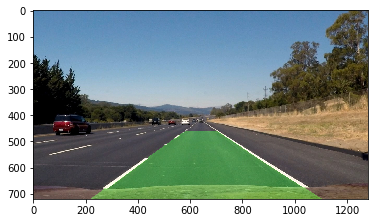

In [89]:
#Visualization of final output
result = visualize(road_img, binary_warped, left_points[0], right_points[0], left_points[1])
#plt.imshow(binary_warped)
plt.imshow(result)

## Image Processing Pipeline

In [90]:
#Image processing pipeline

def process_image(road_img):
    
    road_undist = cv2.undistort(road_img, mtx, dist, None, mtx)
    
    road_warped, Minv, src, dst = perspectiveTransform(road_undist)
    
    color_binary, binary_warped = color_gradient_thresholding(road_warped)
    
    lines_fit, left_points, right_points = find_similar_lane_pixels(binary_warped, False, lanes_fit)
    
    lane_img = visualize(road_img, binary_warped, left_points[0], right_points[0], left_points[1])
    
    result = visualize_data(lane_img, left_points, right_points)
    
    
    return result

In [91]:
white_output = 'solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video solidWhiteRight.mp4
[MoviePy] Writing video solidWhiteRight.mp4


100%|█████████▉| 1260/1261 [04:10<00:00,  5.12it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: solidWhiteRight.mp4 

CPU times: user 1min 45s, sys: 22.4 s, total: 2min 8s
Wall time: 4min 13s


In [92]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))